In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os

# Constants
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
BUFFER_SIZE = 1000
NUM_CLASSES = 3  

In [2]:
# Load the dataset with information
dataset, info = tfds.load("oxford_iiit_pet", with_info=True)
print("Dataset features:", info.features.keys())

Dataset features: dict_keys(['image', 'label', 'species', 'file_name', 'segmentation_mask'])


Sample keys: dict_keys(['file_name', 'image', 'label', 'segmentation_mask', 'species'])
Unique labels in the sample mask: [2 3 1]


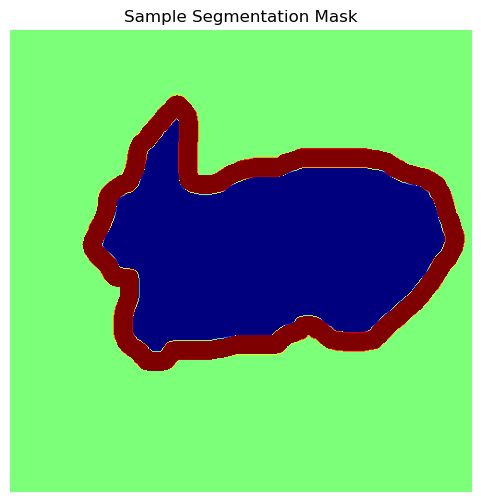

In [5]:
# Inspect a sample to confirm
sample = next(iter(dataset['train'].take(1)))
print("Sample keys:", sample.keys())
image_sample, mask_sample = sample['image'], sample['segmentation_mask']

# Check unique labels in the sample mask
unique_labels = tf.unique(tf.reshape(mask_sample, [-1]))[0].numpy()
print("Unique labels in the sample mask:", unique_labels)

# Visualize the sample mask
plt.figure(figsize=(6,6))
plt.imshow(mask_sample.numpy().squeeze(), cmap='jet')
plt.title('Sample Segmentation Mask')
plt.axis('off')
plt.show()

In [7]:
def preprocess_data(data):
    # Extract image and mask from the data
    image = data['image']
    mask = data.get('segmentation_mask')

    if mask is None:
        print("Mask is missing. Creating a default mask of zeros.")
        mask = tf.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=tf.int32)  # Adjust size as needed
    else:
        print("Original Mask Shape:", mask.shape)

        # Resize the mask using nearest neighbor to preserve labels
        mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        mask = tf.cast(mask, tf.int32)  # Keep as integer labels

        # Subtract 1 to make labels start from 0
        mask = mask - 1
        mask = tf.where(mask < 0, tf.zeros_like(mask), mask)  # Replace negative values with 0

    # Resize image
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))

    # Normalize image
    image = tf.cast(image, tf.float32) / 255.0

    return image, mask

In [9]:
# Split the dataset into training and validation sets
train_dataset = dataset['train'].map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = dataset['test'].map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch the datasets
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Original Mask Shape: (None, None, 1)
Original Mask Shape: (None, None, 1)


In [11]:
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    inputs = tf.keras.layers.Input(input_size)

    # Encoder
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = tf.keras.layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = tf.keras.layers.concatenate([conv4, up6], axis=3)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = tf.keras.layers.concatenate([conv3, up7], axis=3)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = tf.keras.layers.concatenate([conv2, up8], axis=3)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = tf.keras.layers.concatenate([conv1, up9], axis=3)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output Layer for Multi-class Segmentation
    outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])

    # Compile the model with appropriate loss function and metrics
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create the U-Net model
model = unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_7[0][0], 

 Total params: 31,031,875 (118.38 MB)

 Trainable params: 31,031,875 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define steps per epoch
TRAIN_LENGTH = info.splits['train'].num_examples
VAL_LENGTH = info.splits['test'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = VAL_LENGTH // BATCH_SIZE

# Train the model
history = model.fit(train_dataset,
                    epochs=10,  
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALIDATION_STEPS,
                    validation_data=val_dataset)

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5865 - loss: 0.9499

In [ ]:
# Visualization of Predictions
for image_batch, mask_batch in val_dataset.take(1):
    pred_mask = model.predict(image_batch)
    
    # Convert predictions to class labels
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    # Visualize one image, its true mask, and the predicted mask
    plt.figure(figsize=(18, 6))
    
    # Input Image
    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(image_batch[0])
    plt.axis('off')
    
    # True Mask
    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(tf.squeeze(mask_batch[0]), cmap='jet')
    plt.axis('off')
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(tf.squeeze(pred_mask[0]), cmap='jet')
    plt.axis('off')
    
    plt.show()

In [ ]:
# Save the trained model
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
model_save_path = os.path.join(desktop_path, "unet_model.keras")
model.save(model_save_path)
print(f"Model successfully saved to {model_save_path}")